## Hackathon Group 5

**TU Delft and WUR**<br>
**Q1 2024**<br>
**Instructor:** Theodoros Chatzivasileiadis <br>
**Instructor:** Hans Hoogenboom <br>
**Students:** Asal Moradi, Nathalie Waelbroeck, Wessel van Elzakker, Marnix Broersma <br>
**TA:** Ka Yi Chua <br>
**[Metropolitan Data 1](https://jhoogenboom.github.io/spatial-data-science/_index.html)** <br>



__Research Question__

Where are we more likely to find solar panels in the city of Amsterdam?

Is there an equity issue?

We wanted to analyze how different factors affect the adoption of solar in Amsterdam. We found a study by Berkely Lab that investigated a variety of trends regarding solar adoption in the United States. Two variables that stood out to us were the solar-adaption income distributions and owner-occupied housing solar adoption. In this study, the “middle income” group was the biggest group adopting solar panels. A higher share of owner-occupied houses also showed a positive correlation with solar panel adoption (Barbose et al., 2022). We were interested in analyzing the same variables for Amsterdam. We did expect that the different land use pattern would be a large differentiator. Amsterdam has a significant higher population density than the United States, and as stated by Lan et al. (2021), it has a negative effect on solar adoption per capita.

Barbose, G. L., Forrester, S., O’Shaughnessy, E., & Darghouth, N. R. (2022, 25 februari). Residential Solar-Adopter Income and Demographic Trends: 2022 Update. https://escholarship.org/uc/item/5vd6w51m

Lan, H., Gou, Z., & Lu, Y. (2021). Machine Learning approach to understand regional disparity of residential solar adoption in Australia. Renewable And Sustainable Energy Reviews, 126, 110458.


__Importing the Libraries__

We imported the libraries that would support our analysis.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pysal as ps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.api import OLS

__Loading the spatial data__

Description

__Loading the data__

* nl_wp_Wonen = total solar energy production on residential buildings.
* Property: Owner-occupied = total number of owner-occupied housing units
* Mean disposable household income = Income
* Population density = number of people per sq.km.

In [2]:
df_solar = pd.read_excel("hackathon/Solar panels.xlsx", usecols=["Area", "Year", "nl_wp_Wonen"], index_col="Area")
df_housing = pd.read_excel("hackathon/Housing.xlsx", usecols=["Area", "Property: Owner-occupied"], index_col="Area")
df_income = pd.read_excel("hackathon/Income.xlsx", usecols=["Area", "Mean disposable household income"], index_col="Area")
df_population = pd.read_excel("hackathon/Population.xlsx", usecols=["Area", "Population density"], index_col="Area")

__Cleaning the data__

We merged and trimmed the data to only include information from the year 2021. We also kept only the essential data described above. In addition:
* we dropped 2 lines of missing data
* we replaced the '-' for 0s
* we converted objects to integers.

In [3]:
df_solar = df_solar.loc[df_solar["Year"] == 2021]   # We only want to use data from 2021 for data consistency.
df_solar = df_solar.drop(columns=["Year"])

In [4]:
hd = pd.concat([df_housing, df_income, df_population, df_solar], axis=1)

hd = hd.dropna()    # only 2 lines are missing data, so we felt it was ok to drop those.
hd = hd.replace('-', 0)     # we noticed there are - in industrial areas where we wouldn't expect housing to exist. So we assume - is equivalent to 0.

# two columns were clearly numbers, but were categorized as objects. We converted them to integers to support the statistical analysis.
hd.astype({'Mean disposable household income': 'int64', 'Population density': 'int64'}).dtypes
hd.dtypes

hd

C:\Users\marni\AppData\Local\Temp\ipykernel_12296\1339664075.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hd = hd.replace('-', 0)     # we noticed there are - in industrial areas where we wouldn't expect housing to exist. So we assume - is equivalent to 0.


,Property: Owner-occupied,Mean disposable household income,Population density,nl_wp_Wonen
Area,,,,
Haarlemmerbuurt,1556,49800,17126,252054.0
Jordaan,3236,46700,23298,276128.0
Grachtengordel-West,1656,83300,14217,75086.0
Burgwallen-Nieuwe Zijde,522,44300,7182,45236.0
Burgwallen-Oude Zijde,526,40800,12986,14979.0
...,...,...,...,...
K-buurt,846,37000,8248,904655.0
Holendrecht,822,35000,7220,1038394.0
Nellestein,679,38600,1418,166320.0


__Descriptive Statistics__

In [5]:
summary = hd.groupby('Area').agg({  
    'Property: Owner-occupied': ['mean', 'median', 'std', 'min', 'max'],  
    'Mean disposable household income': ['mean', 'median', 'std', 'min', 'max'],  
    'Population density': ['mean', 'median', 'std', 'min', 'max'],
    'nl_wp_Wonen': ['mean', 'median', 'std', 'min', 'max'],  
})  

# Reset index to make the neighborhood column a regular column  
summary.reset_index(inplace=True)  

summary.head()

Area Property: Owner-occupied                          \
                                              mean  median std   min   max   
0    Amstel III/Bullewijk                      6.0     6.0 NaN     6     6   
1  Amsterdamse Poort e.o.                    705.0   705.0 NaN   705   705   
2             Apollobuurt                   2019.0  2019.0 NaN  2019  2019   
3         Banne Buiksloot                   1864.0  1864.0 NaN  1864  1864   
4            Bellamybuurt                    888.0   888.0 NaN   888   888   

  Mean disposable household income                        ...  \
                              mean    median std     min  ...   
0                          29600.0   29600.0 NaN   29600  ...   
1                          35800.0   35800.0 NaN   35800  ...   
2                         119800.0  119800.0 NaN  119800  ...   
3                          39700.0   39700.0 NaN   39700  ...   
4                          46900.0   46900.0 NaN   46900  ...   

  Population density                            nl_wp_Wonen                 \
                mean   median std    min    max        mean     median std   
0              334.0    334.0 NaN    334    334    398248.0   398248.0 NaN   
1             5915.0   5915.0 NaN   5915   5915    458259.0   458259.0 NaN   
2             9631.0   9631.0 NaN   9631   9631    245425.0   245425.0 NaN   
3             9014.0   9014.0 NaN   9014   9014   2093177.0  2093177.0 NaN   
4            26711.0  26711.0 NaN  26711  26711    284667.0   284667.0 NaN   

                         
         min        max  
0   398248.0   398248.0  
1   458259.0   458259.0  
2   245425.0   245425.0  
3  2093177.0  2093177.0  
4   284667.0   284667.0  

[5 rows x 21 columns]

## Correlation coefficient

In [6]:
# Calculate the correlation coefficient. Give me a short definition of this coefficient

print('Property Owner Occupied:', hd['nl_wp_Wonen'].corr(hd['Property: Owner-occupied']))
print('conclusion: people who own their homes are more likely to have solar panels')
print('')
print('Population density:', hd['nl_wp_Wonen'].corr(hd['Population density']))
print('conclusion: the higher the population density, the less renewable energy per person is generated')
print('')
print('Mean disposable household income:', hd['nl_wp_Wonen'].corr(hd['Mean disposable household income']))
print('conclusion: in Amsterdam, there is no correlation between household income and availability of solar power')

Property Owner Occupied: 0.46467266578492894
conclusion: people who own their homes are more likely to have solar panels

Population density: -0.259872688648808
conclusion: the higher the population density, the less renewable energy per person is generated

Mean disposable household income: 0.04276700834720231
conclusion: in Amsterdam, there is no correlation between household income and availability of solar power


## Scatter plot

We looked in more detail why there was no correlation between the mean disposable household income and solar generation by creating a scatter plot. We determined that you need a minimum income in order to be able to have solar panels (approximately 25,000), but at that point, income no longer is relevant. Also we are observing that there is a larger number of middle-income households and less high-income households, which is what we would expect to see. 

<Axes: xlabel='Mean disposable household income', ylabel='nl_wp_Wonen'>

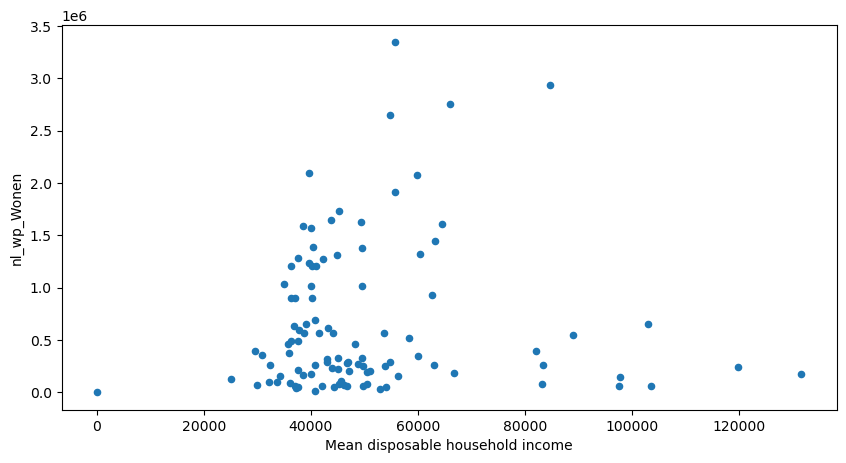

In [7]:
# create a scatter plot showing the relationship between 
hd.plot(kind='scatter', y='nl_wp_Wonen', x='Mean disposable household income', figsize=(10,5))

## Statistics
- Mean
- Median
- Standard Deviation
- Range
- Create a histogram or box plot for at least one of the numerical features, highlighting any skewness or outliers.

We were unable to derive a comclusion, but we left the code in.

In [8]:
print("mean is", hd['Population density'].mean())
print("median is", hd['Population density'].median())
print("standard deviation is", hd['Population density'].std())

a = hd['Population density'].min()
b = hd['Population density'].max()

print("the minimum rating is", a, "the maximum rating is", b)

mean is 11365.669902912621
median is 9713.0
standard deviation is 7682.881076462506
the minimum rating is 0 the maximum rating is 28699


In [9]:
print("mean is", hd['Property: Owner-occupied'].mean())
print("median is", hd['Property: Owner-occupied'].median())
print("standard deviation is", hd['Property: Owner-occupied'].std())

a = hd['Property: Owner-occupied'].min()
b = hd['Property: Owner-occupied'].max()

print("the minimum rating is", a, "the maximum rating is", b)

mean is 1235.9514563106795
median is 1082.0
standard deviation is 784.8684962743356
the minimum rating is 5 the maximum rating is 3567


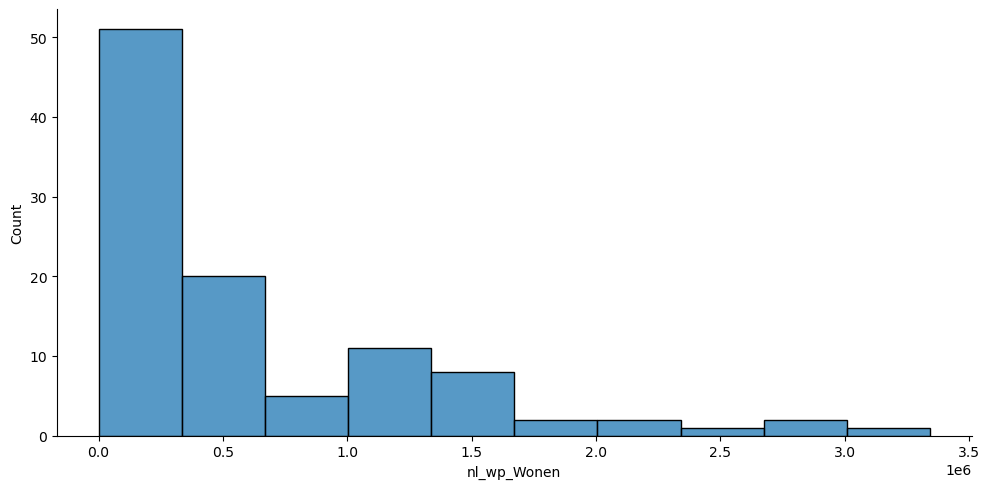

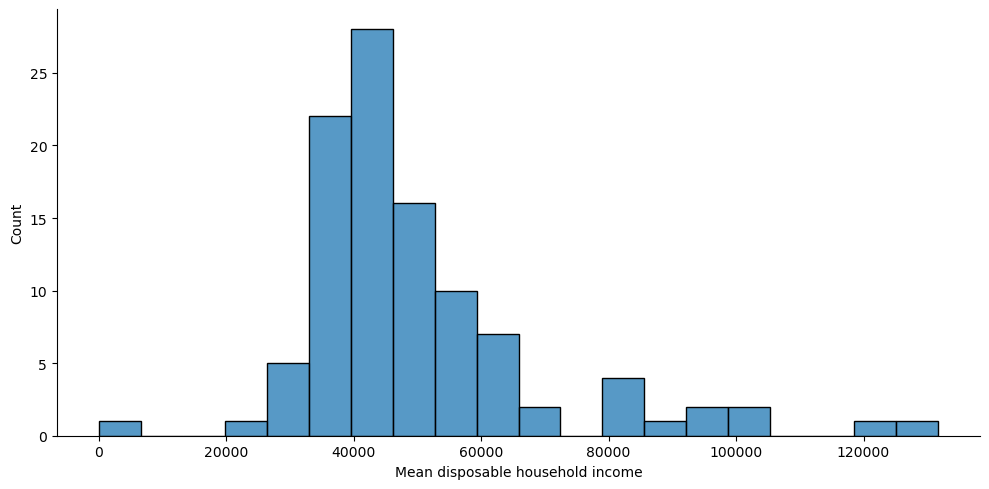

In [10]:
sns.displot(hd['nl_wp_Wonen'], aspect=2)
sns.displot(hd['Mean disposable household income'], aspect=2)

# Regression Analysis

We made a number of univariate linear regression models, to see which of the independent variables (income, home ownership, population density) has the strongest effect on the solar energy produced in a neighborhood (the dependent variable).
The accuracy score of these models can be compared to see how well the dependent variable can be predicted by the independent variables. 
We also tried a multivariate model, but we found this gives little insight in the difference between factors.

In [13]:
#The same steps for data cleaning are applied as before. 

df = pd.concat([df_housing, df_income, df_population, df_solar], axis=1)
df = df.dropna()
df = df.replace('-', 0)
df.sort_values(by=['Property: Owner-occupied'])
df.astype({'Mean disposable household income': 'int64', 'Population density': 'int64'}).dtypes
df.dtypes

C:\Users\marni\AppData\Local\Temp\ipykernel_12296\746939556.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('-', 0)


Property: Owner-occupied              int64
Mean disposable household income      int64
Population density                    int64
nl_wp_Wonen                         float64
dtype: object

For regression, the dataset is divided in a training set (80% of data) and a test set (20% of data.)

In [14]:
train_df, test_df = train_test_split(df, test_size=0.2)

For every independent variable, a linear regression model is made. These are univariate models where the dependent variable is the energy output by solar panels.

We made use of the LinearRegression() functon of sklearn.

In [15]:
# creating a regression model with sklearn
x_train_hos = train_df[['Property: Owner-occupied']].copy()
x_train_income = train_df[['Mean disposable household income']].copy()
x_train_density = train_df[['Population density']].copy()
x_test_hos = test_df[['Property: Owner-occupied']].copy()
x_test_income = test_df[['Mean disposable household income']].copy()
x_test_density = test_df[['Population density']].copy()

y_train = train_df['nl_wp_Wonen'].copy()
y_test = test_df['nl_wp_Wonen'].copy()

#Fitting the models generates parameters.
model_hos = LinearRegression().fit(x_train_hos,y_train)
model_income = LinearRegression().fit(x_train_income,y_train)
model_density = LinearRegression().fit(x_train_density,y_train)

The models are scored using the R^2 value, which is an indicator of the goodness of a fit of the model. 

In [18]:
#scoring the models
print(f"The r2 score for home ownership univariate model = {model_hos.score(x_test_hos, y_test)}")
print(f"The r2 score for income univariate model = {model_income.score(x_test_income, y_test)}")
print(f"The r2 score for population density univariate model = {model_density.score(x_test_density, y_test)}")

The r2 score for home ownership univariate model = 0.07205869099304918
The r2 score for income univariate model = -0.002294556459378816
The r2 score for population density univariate model = 0.07261007475756642


The fit of every model model on the test set is plotted in the graphs below. 

Text(0, 0.5, 'Solar energy production (kwh)')

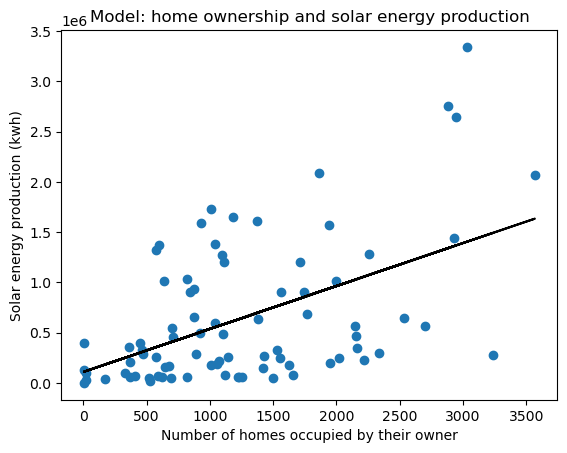

In [21]:
prediction = model_hos.predict(x_train_hos)
#Plotting the predicted line
plt.plot(x_train_hos['Property: Owner-occupied'],prediction, color='k', label="Prediction")
#Scatterplot of test data
plt.scatter(x_train_hos, y_train, label="Test Data")
plt.title("Model: home ownership and solar energy production")
plt.xlabel('Number of homes occupied by their owner')
plt.ylabel('Solar energy production (kwh)')

Text(0, 0.5, 'Solar energy production (kwh)')

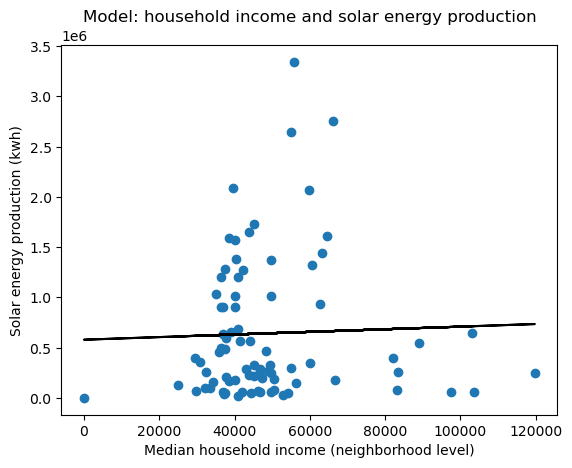

In [27]:
prediction = model_income.predict(x_train_income)
#Plotting the predicted line
plt.plot(x_train_income['Mean disposable household income'],prediction, color='k', label="Prediction")
#Scatterplot of test data
plt.scatter(x_train_income, y_train, label="Test Data")
plt.title("Model: household income and solar energy production")
plt.xlabel('Median household income (neighborhood level)')
plt.ylabel('Solar energy production (kwh)')

Text(0, 0.5, 'Solar energy production (kwh)')

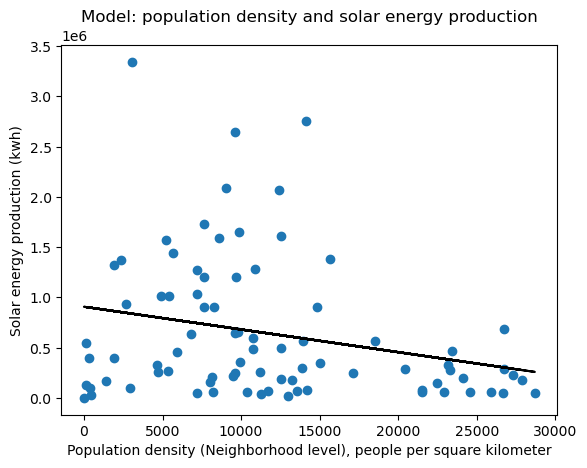

In [26]:
prediction = model_density.predict(x_train_density)
#Plotting the predicted line
plt.plot(x_train_density['Population density'],prediction, color='k', label="Prediction")
#Scatterplot of test data
plt.scatter(x_train_density, y_train, label="Test Data")
plt.title("Model: population density and solar energy production")
plt.xlabel('Population density (Neighborhood level), people per square kilometer')
plt.ylabel('Solar energy production (kwh)')